In [6]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float

from skimage.feature import peak_local_max
from skimage import io
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.color import rgb2gray
from skimage import util 
from skimage.morphology import erosion, dilation
from skimage.morphology import disk

from scipy.ndimage import gaussian_filter
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy import ndimage as ndi
import numpy as np


In [7]:
def image_proccessing(img, show = True):
    
    image = rgb2gray(img)
    
    image_data = img_as_float(image)

    seed = np.copy(image_data)
    seed[1:-1, 1:-1] = image_data.min()
    mask = image_data
    image_dilatated = reconstruction(seed, mask, method='dilation')

    image_inverted = util.invert(image_dilatated)
    
    image_max = ndi.maximum_filter(image_inverted, size=5, mode='constant')

    image_gaussian = gaussian_filter(image_max, 1)

    coordinates = peak_local_max(image_gaussian, min_distance=50)
    
    if show:
        fig, axes = plt.subplots(3, 1, figsize=(10, 25), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].axis('off')
        ax[0].set_title('Original')

        ax[1].imshow(image_max, cmap=plt.cm.gray)
        ax[1].axis('off')
        ax[1].set_title('Maximum filter')

        ax[2].imshow(image, cmap=plt.cm.gray)
        ax[2].autoscale(False)
        ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
        ax[2].axis('off')
        ax[2].set_title('Centroids')
        fig.tight_layout()
        
        plt.rcParams["figure.figsize"] = (15,10)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
        plt.show()
    return coordinates

In [8]:

def voronoi(vor, coord):
    
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    radius = vor.points.ptp().max()

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]]) 

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

        for region in new_regions:
            polygon = np.asarray(new_vertices)[region]
            plt.fill(*zip(*polygon), alpha=0.4)

        plt.plot(coord[:,0], coord[:,1], 'ko')
        plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
        plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)


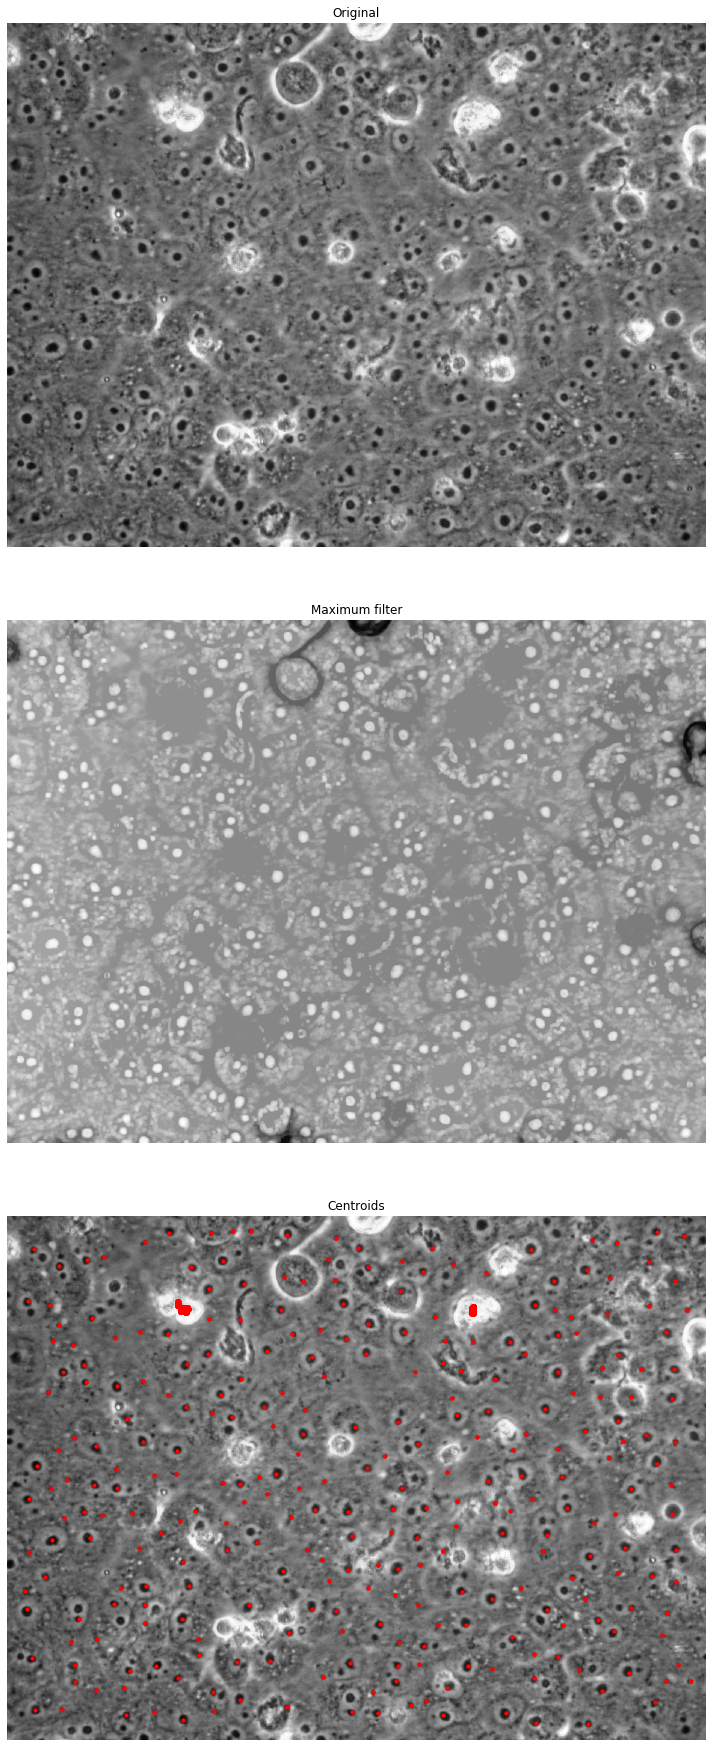

In [47]:
image = io.imread('4/HBoV/40x/HBoV1_72_часа_(40х)_3.png')

coordinates = image_proccessing(image)


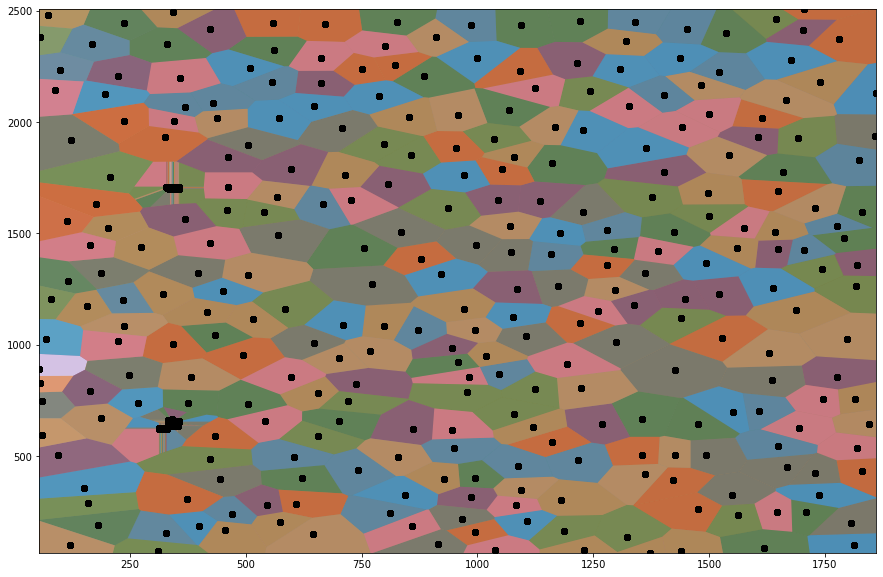

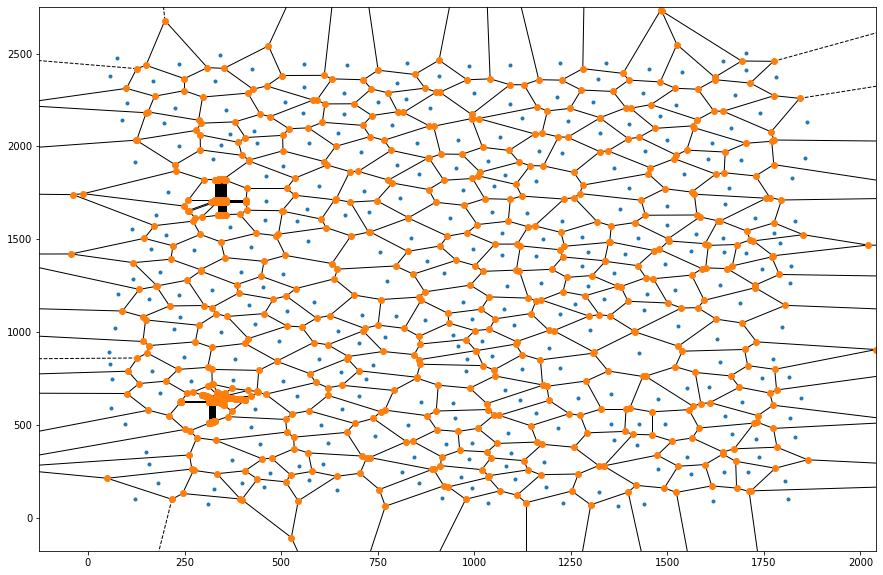

In [48]:
vor = Voronoi(coordinates)
voronoi(vor, coordinates)
plt.rcParams["figure.figsize"] = (15,10)
voronoi_plot_2d(vor)
plt.show()